In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 3.0MB/s 
     |████████████████████████████████| 3.3MB 17.8MB/s 
     |████████████████████████████████| 870kB 27.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=81575ef188a0119ae0b4fe6dfce2686ac8ac335641aa83f57f2f384b2311f834
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import torch

In [ ]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
question = "Who is the captain of the Indian Cricket team?"
answer_text = "MS Dhoni captained the team till 2016. After that Virat Kohli was appointed"

In [ ]:
# Applying the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 30 tokens.


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, we add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Printing the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
who           2,040
is            2,003
the           1,996
captain       2,952
of            1,997
the           1,996
indian        2,796
cricket       4,533
team          2,136
?             1,029

[SEP]           102

ms            5,796
dh           28,144
##oni        10,698
captained    16,041
the           1,996
team          2,136
till          6,229
2016          2,355
.             1,012
after         2,044
that          2,008
vi            6,819
##rat         8,609
ko           12,849
##hli        27,766
was           2,001
appointed     2,805

[SEP]           102



In [ ]:
# Searching the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

num_seg_b = len(input_ids) - num_seg_a

# Constructing the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [ ]:
# Run our example through the model.
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [ ]:
# Finding the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combining the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "vi ##rat ko ##hli"


In [ ]:
# Starting with the first token.
answer = tokens[answer_start]

# Selecting the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then we need to recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, we add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "virat kohli"


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using plot styling from seaborn.
sns.set(style='darkgrid')

# Increasing the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
# Pulling the scores out of PyTorch Tensors and converting them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


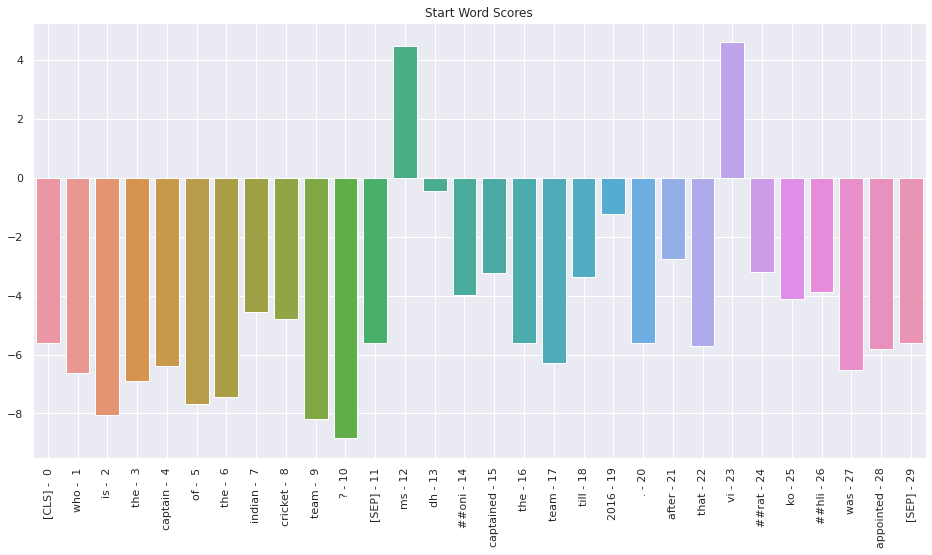

In [ ]:
# Creating a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turning the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turning on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

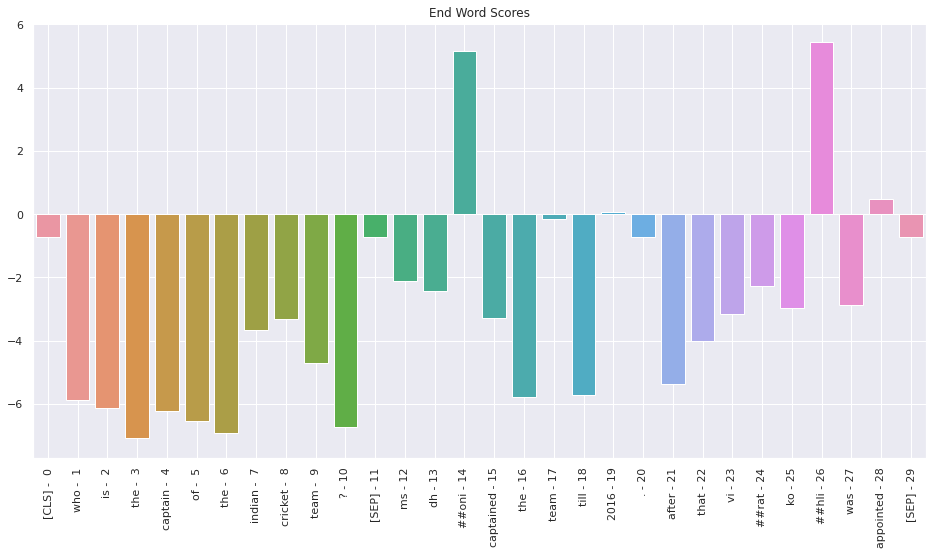

In [ ]:
# Creating a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turning the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turning on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [ ]:
import pandas as pd

# Storing the tokens and scores in a DataFrame. 
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


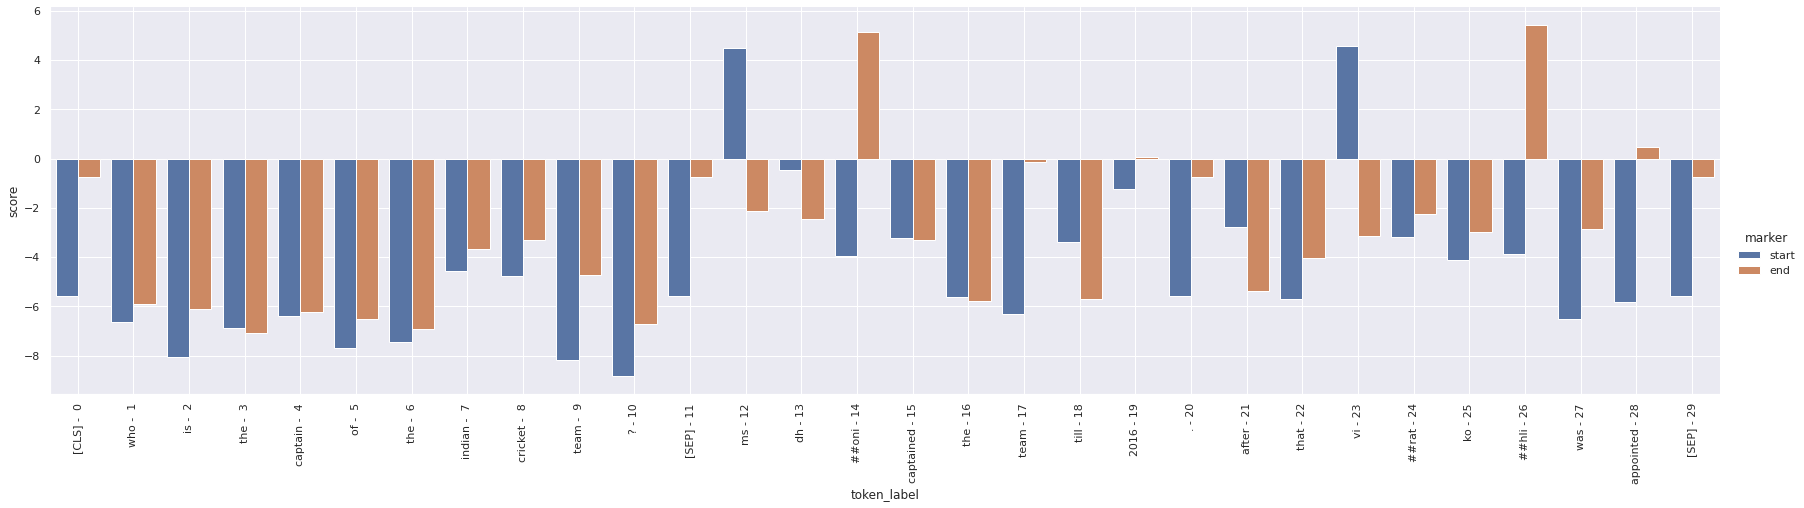

In [ ]:
# Drawing a grouped barplot to show start and end scores for each word.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turning the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turning on the vertical grid to help align words to scores.
g.ax.grid(True)